In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random

In [2]:
n_timesteps_in = 10 
n_timesteps_out = 15
n_features_in = 1
n_features_out = 1

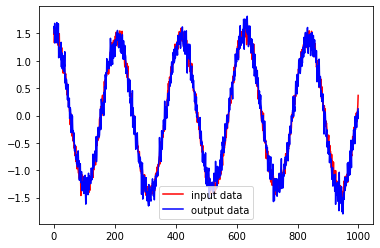

In [3]:
time_series_length = 1000
t = np.linspace(0, 10, time_series_length)
ts_input = np.cos(t) / 5 + 5 * np.cos(t*3) + 0.3 * np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t) / 3 + 5 * np.cos(t*3) + 0.5 * np.random.standard_normal(size=time_series_length)

ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input data')
plt.plot(ts_norm_output,'b', label = 'output data')

plt.legend()

In [4]:
train_size = int(len(ts_input) * 0.75)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

In [5]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)

    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)

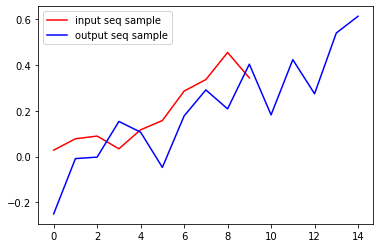

In [6]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()
plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()

In [7]:
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

In [8]:
n_units = 256

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [9]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 15, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        264192      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [10]:
model.compile(optimizer='adam', loss='mse')
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.3, callbacks = my_callbacks, verbose=2)

Epoch 1/100
6/6 - 3s - loss: 0.5836 - val_loss: 0.2120 - 3s/epoch - 573ms/step
Epoch 2/100
6/6 - 0s - loss: 0.1191 - val_loss: 0.0816 - 274ms/epoch - 46ms/step
Epoch 3/100
6/6 - 0s - loss: 0.0835 - val_loss: 0.0528 - 282ms/epoch - 47ms/step
Epoch 4/100
6/6 - 0s - loss: 0.0493 - val_loss: 0.0638 - 288ms/epoch - 48ms/step
Epoch 5/100
6/6 - 0s - loss: 0.0511 - val_loss: 0.0426 - 278ms/epoch - 46ms/step
Epoch 6/100
6/6 - 0s - loss: 0.0438 - val_loss: 0.0386 - 277ms/epoch - 46ms/step
Epoch 7/100
6/6 - 0s - loss: 0.0415 - val_loss: 0.0391 - 278ms/epoch - 46ms/step
Epoch 8/100
6/6 - 0s - loss: 0.0404 - val_loss: 0.0392 - 317ms/epoch - 53ms/step
Epoch 9/100
6/6 - 0s - loss: 0.0384 - val_loss: 0.0350 - 304ms/epoch - 51ms/step
Epoch 10/100
6/6 - 0s - loss: 0.0374 - val_loss: 0.0344 - 300ms/epoch - 50ms/step
Epoch 11/100
6/6 - 0s - loss: 0.0373 - val_loss: 0.0339 - 297ms/epoch - 50ms/step
Epoch 12/100
6/6 - 0s - loss: 0.0357 - val_loss: 0.0337 - 272ms/epoch - 45ms/step
Epoch 13/100
6/6 - 0s - los

In [11]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

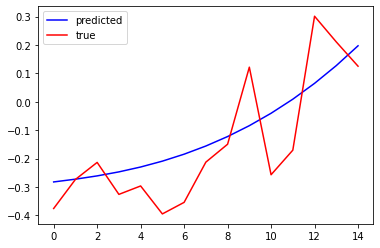

In [12]:
plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf

In [4]:
train_data = pd.read_csv(r'C:\Users\Dimotik\Desktop\fashion-mnist_train.csv')
X_train = train_data.drop('label',axis=1)
X_train=X_train.values
print(X_train.shape)

(60000, 784)


In [5]:
X_train=X_train.reshape(-1,28,28,1)
print(X_train.shape)

(60000, 28, 28, 1)


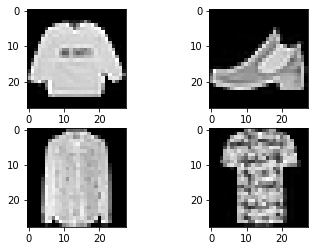

In [6]:
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=1

In [7]:
X_train =  X_train.astype('float32')
X_train = X_train/255
X_train = X_train*2 - 1.

In [8]:
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

In [9]:
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [10]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [11]:
epochs = 100
batch_size = 64
noise_shape=100

Epoch 1
	batch number 500 of 937


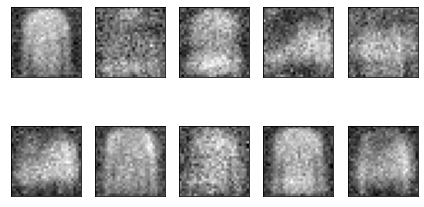

Epoch 2
	batch number 500 of 937
Epoch 3
	batch number 500 of 937
Epoch 4
	batch number 500 of 937
Epoch 5
	batch number 500 of 937
Epoch 6
	batch number 500 of 937
Epoch 7
	batch number 500 of 937
Epoch 8
	batch number 500 of 937
Epoch 9
	batch number 500 of 937
Epoch 10
	batch number 500 of 937
Epoch 11
	batch number 500 of 937


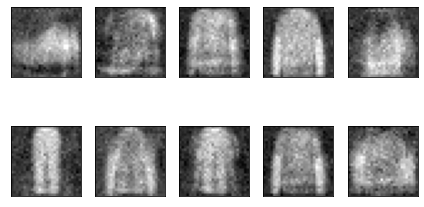

Epoch 12
	batch number 500 of 937
Epoch 13
	batch number 500 of 937
Epoch 14
	batch number 500 of 937
Epoch 15
	batch number 500 of 937
Epoch 16
	batch number 500 of 937
Epoch 17
	batch number 500 of 937
Epoch 18
	batch number 500 of 937
Epoch 19
	batch number 500 of 937
Epoch 20
	batch number 500 of 937
Epoch 21
	batch number 500 of 937


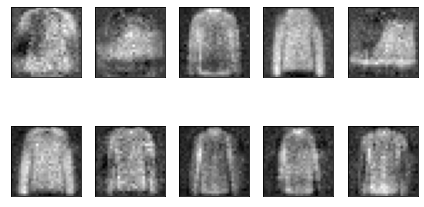

Epoch 22
	batch number 500 of 937
Epoch 23
	batch number 500 of 937
Epoch 24
	batch number 500 of 937
Epoch 25
	batch number 500 of 937
Epoch 26
	batch number 500 of 937
Epoch 27
	batch number 500 of 937
Epoch 28
	batch number 500 of 937
Epoch 29
	batch number 500 of 937
Epoch 30
	batch number 500 of 937
Epoch 31
	batch number 500 of 937


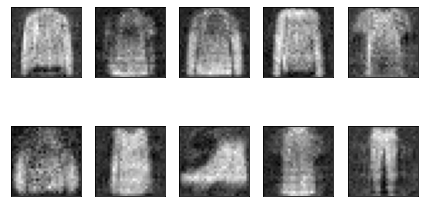

Epoch 32
	batch number 500 of 937
Epoch 33
	batch number 500 of 937
Epoch 34
	batch number 500 of 937
Epoch 35
	batch number 500 of 937
Epoch 36
	batch number 500 of 937
Epoch 37
	batch number 500 of 937
Epoch 38
	batch number 500 of 937
Epoch 39
	batch number 500 of 937
Epoch 40
	batch number 500 of 937
Epoch 41
	batch number 500 of 937


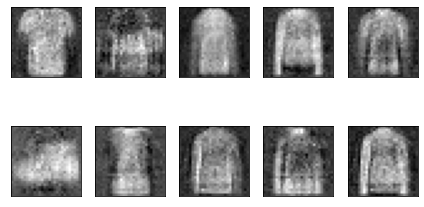

Epoch 42
	batch number 500 of 937
Epoch 43
	batch number 500 of 937
Epoch 44
	batch number 500 of 937
Epoch 45
	batch number 500 of 937
Epoch 46
	batch number 500 of 937
Epoch 47
	batch number 500 of 937
Epoch 48
	batch number 500 of 937
Epoch 49
	batch number 500 of 937
Epoch 50
	batch number 500 of 937
Epoch 51
	batch number 500 of 937


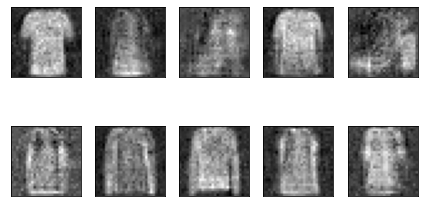

Epoch 52
	batch number 500 of 937
Epoch 53
	batch number 500 of 937
Epoch 54
	batch number 500 of 937
Epoch 55
	batch number 500 of 937
Epoch 56
	batch number 500 of 937
Epoch 57
	batch number 500 of 937
Epoch 58
	batch number 500 of 937
Epoch 59
	batch number 500 of 937
Epoch 60
	batch number 500 of 937
Epoch 61
	batch number 500 of 937


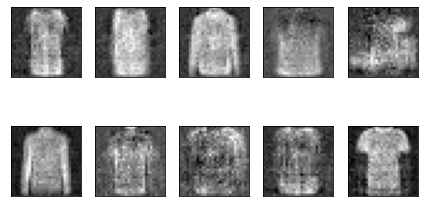

Epoch 62
	batch number 500 of 937
Epoch 63
	batch number 500 of 937
Epoch 64
	batch number 500 of 937
Epoch 65
	batch number 500 of 937
Epoch 66
	batch number 500 of 937
Epoch 67
	batch number 500 of 937
Epoch 68
	batch number 500 of 937
Epoch 69
	batch number 500 of 937
Epoch 70
	batch number 500 of 937
Epoch 71
	batch number 500 of 937


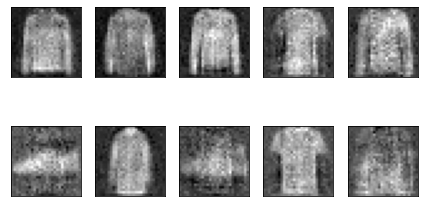

Epoch 72
	batch number 500 of 937
Epoch 73
	batch number 500 of 937
Epoch 74
	batch number 500 of 937
Epoch 75
	batch number 500 of 937
Epoch 76
	batch number 500 of 937
Epoch 77
	batch number 500 of 937
Epoch 78
	batch number 500 of 937
Epoch 79
	batch number 500 of 937
Epoch 80
	batch number 500 of 937
Epoch 81
	batch number 500 of 937


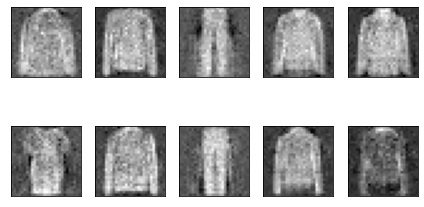

Epoch 82
	batch number 500 of 937
Epoch 83
	batch number 500 of 937
Epoch 84
	batch number 500 of 937
Epoch 85
	batch number 500 of 937
Epoch 86
	batch number 500 of 937
Epoch 87
	batch number 500 of 937
Epoch 88
	batch number 500 of 937
Epoch 89
	batch number 500 of 937
Epoch 90
	batch number 500 of 937
Epoch 91
	batch number 500 of 937


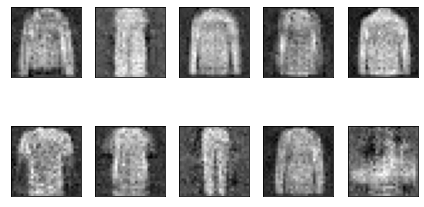

Epoch 92
	batch number 500 of 937
Epoch 93
	batch number 500 of 937
Epoch 94
	batch number 500 of 937
Epoch 95
	batch number 500 of 937
Epoch 96
	batch number 500 of 937
Epoch 97
	batch number 500 of 937
Epoch 98
	batch number 500 of 937
Epoch 99
	batch number 500 of 937
Epoch 100
	batch number 500 of 937


In [12]:
 for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    
    
    for i in range(X_train.shape[0]//batch_size):
        
        if (i+1)%500 == 0:
            print(f"\tbatch number {i+1} of {X_train.shape[0]//batch_size}")
            
        noise=np.random.normal(size=[batch_size,noise_shape])
       
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
       
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)
        
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)
        
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
        
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()
        
noise=np.random.normal(size=[10,noise_shape])
gen_image = generator.predict(noise)

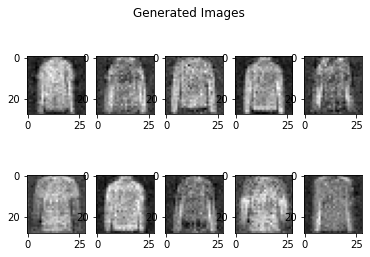

In [13]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1